# C1
# Прогнозирование временных рядов

## курс "Машинное обучение 2", программа OzonMasters, 2022

## Студент: Арешин Станислав Олегович

## Baseline 1

В данном ноутбуке представлено решение, которое побило первый бейслайн. Скор решения на паблике 15.92324 при бейслайне 26.23138.

**Идея решения**

* В ходе проведения EDA было выявлено, что период цикла рядов 24 значения, соответственно первым шагом было выбрать в качестве признаков предыдущие 24 значения каждого временного ряда. 
* Было решено обучать для каждого временного ряда свою модель линейной регрессии, благо это происходит довольно быстро.
* Для составления лагов в обучающей выборке реализована функция  get_lag_features, появившиеся наны просто удаляются.
* Для предсказания значений все немного сложнее. Реализована функция get_last_vals, которая выделяет из обучения последние n значений каждого ряда для первого предикта на тесте. Затем эти значения подаются в функцию make_prediction, которая работает следующим образом: для каждого ряда обучается модель линейной регрессии (в данном случае Ridge регрессии), первый предикт делается по последним значениям трейна, затем значения сдвигаются на 1, а предкит текущего шага добавляется как первый лаг для следующего шага. В результате таким рекурсивным добавлением делаются предсказания, ошибка не сильно накапливается. Минусы такого подхода - сам процесс предсказания происходит довольно долго.
* Также в ходе проведения EDA было выявлено, что min24 и max24 выделяют нижние и верхние границы ряда, а MA24 выделяет тренд. Поэтому было решено с помощью линейной регрессии сгенерировать дополнительные признаки.
* Для выделения тренда обучается линейная регрессия на vals_id и vals_id^2 (для выделения нелинейности), в качестве целевой величины используем value. Такая операция проводится для каждого ряда, делаются предсказания на тест и полученные значения используются в качестве признаков.
* Аналогичные действия проводим, используя min24 и max24 как целевую величину, прогнозируем на будущее и используем как признаки.
* Так как признаков довольно много, было решено использовать Ridge регрессию.


# Загрузка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import warnings
from tqdm import tqdm
warnings.filterwarnings("ignore")

sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

%matplotlib inline

In [2]:
df_train = pd.read_parquet('train.parquet', engine='pyarrow')
df_train.head()

,item_id,vals_id,epoch,value
0,0,0,2014-01-01 00:00:00,3.237531
1,0,1,2014-01-01 00:18:57,1.835517
2,0,2,2014-01-01 00:37:54,0.751695
3,0,3,2014-01-01 00:56:51,0.077846
4,0,4,2014-01-01 01:15:48,-0.161371


In [3]:
df_test = pd.read_parquet('test.parquet', engine='pyarrow')
df_test.head()

,item_id,vals_id,epoch
0,0,3646,2014-02-17 23:31:42
1,0,3647,2014-02-17 23:50:39
2,0,3648,2014-02-18 00:09:36
3,0,3649,2014-02-18 00:28:33
4,0,3650,2014-02-18 00:47:30


In [4]:
submission_sample = pd.read_csv('submission_sample.csv')
print(len(submission_sample))
submission_sample.head()

780762


,row,value
0,0_3646,0.202660
1,0_3647,0.671267
2,0_3648,0.675564
3,0_3649,0.179560
4,0_3650,0.615844


# Генерация признаков

In [8]:
# зададим количество лагов

num_lags = 24

In [9]:
from sklearn.linear_model import LinearRegression

train_trend = []
test_trend = []

for item_id in tqdm(set(df_train['item_id'].values)):
    
    train =  np.array(df_train[df_train['item_id'] == item_id]['vals_id'])
    test = np.array(df_test[df_test['item_id'] == item_id]['vals_id'])
    
    X_train = np.concatenate([[train], [train ** 2]], axis = 0).T
    y_train =  np.array(df_train[df_train['item_id'] == item_id]['value'])
    X_test = np.concatenate([[test], [test ** 2]], axis = 0).T
    
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)
    train_trend += list(train_preds)
    test_trend += list(test_preds)
    
print(len(train_trend), len(df_train))
print(len(test_trend), len(df_test))

100%|██████████████████████████████████████████████████████████████████████████████| 3600/3600 [01:06<00:00, 54.10it/s]

3115734 3115734
780762 780762


In [10]:
df_train['trend'] = train_trend
df_test['trend'] = test_trend

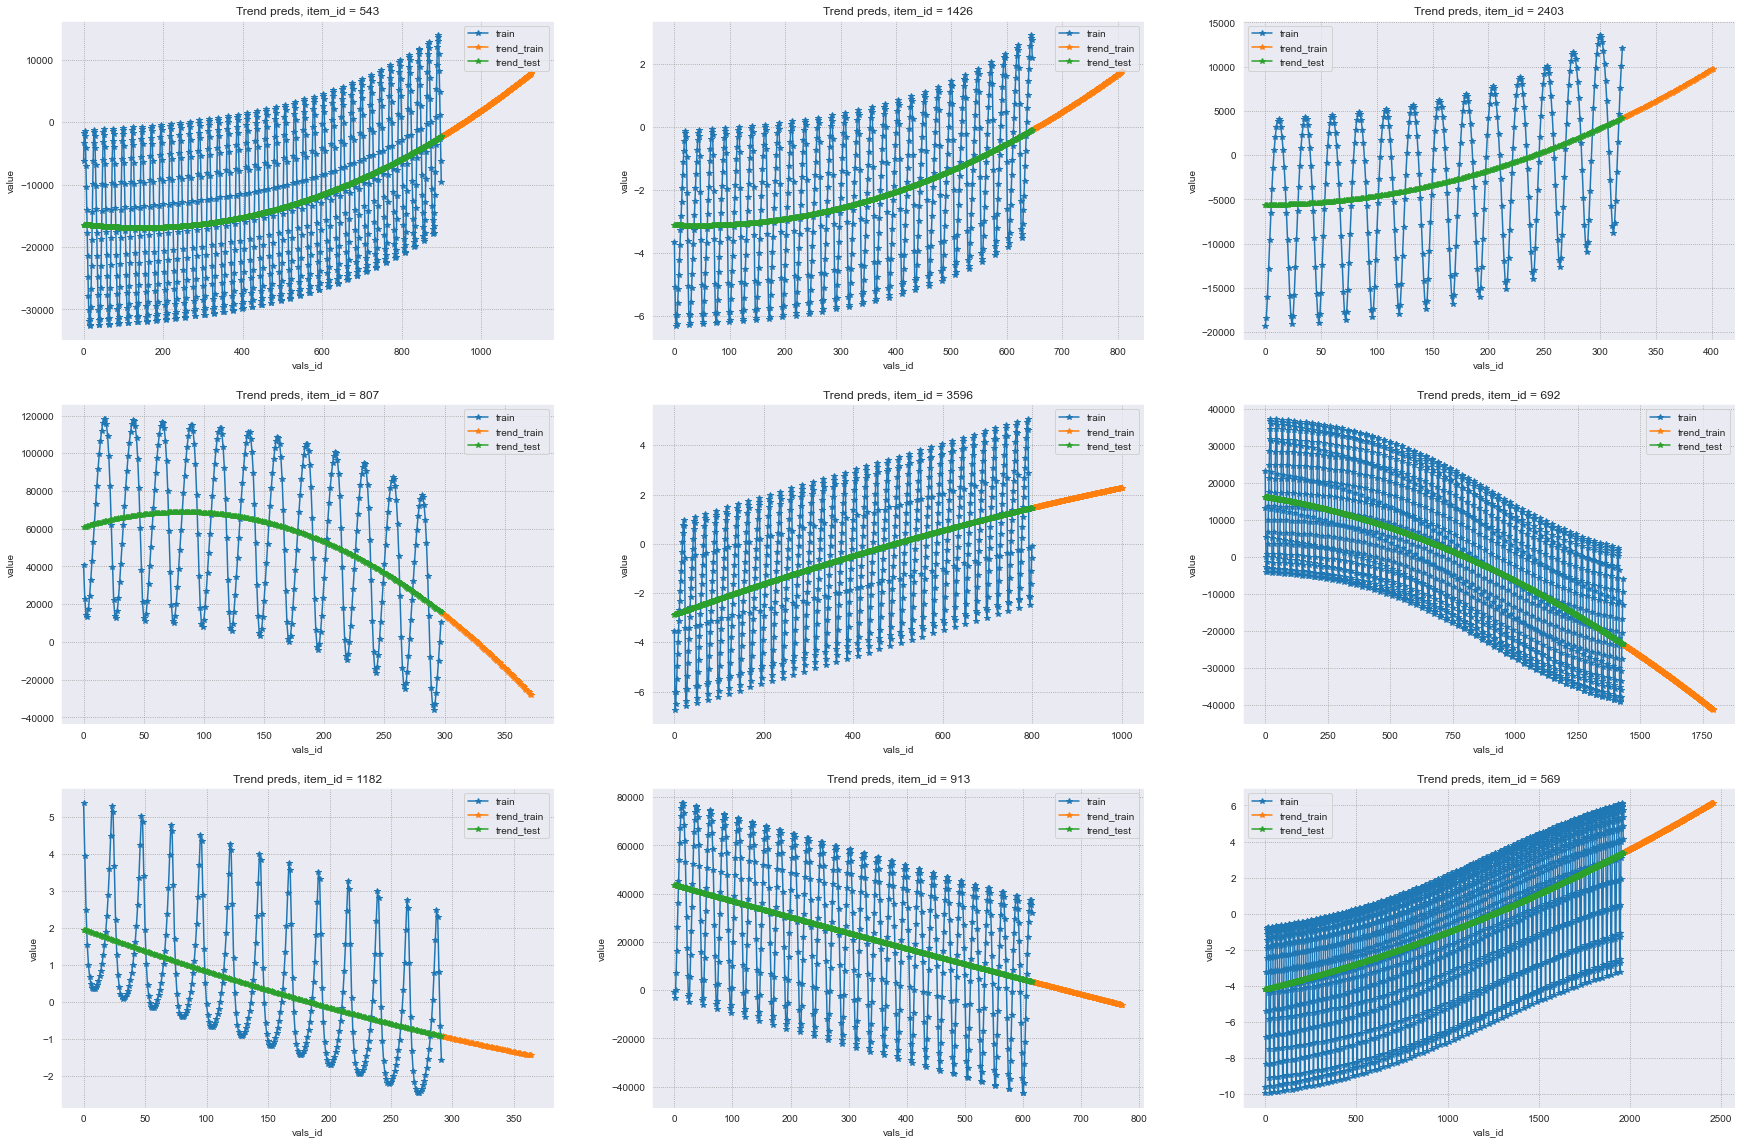

In [16]:
# визуализируем 9 случайных результатов
random_ind = np.random.choice(list(set(df_train['item_id'].values)), 9, replace=False)
plt.figure(figsize = (30, 20))
for i, j in enumerate(random_ind):
    ax = plt.subplot(round(len(random_ind) / 3), 3, i + 1)
    ax.set_title(f'Trend preds, item_id = {j}')
    ax.plot(np.array(df_train[df_train['item_id'] == j]['vals_id']),
             np.array(df_train[df_train['item_id'] == j]['value']), label='train', marker = '*')
    ax.plot(np.array(df_test[df_test['item_id'] == j]['vals_id']),
         np.array(df_test[df_test['item_id'] == j]['trend']), label = 'trend_train',
        marker = '*')
    ax.plot(np.array(df_train[df_train['item_id'] == j]['vals_id']),
         np.array(df_train[df_train['item_id'] == j]['trend']), label = 'trend_test',
        marker = '*')
    ax.legend()
    ax.set_xlabel('vals_id')
    ax.set_ylabel('value')
plt.show()

In [17]:
def get_lag_features(df, num_lags):
    for i in range(1, num_lags + 1):
        df[f'lag{i}'] =  df.groupby('item_id')['value'].shift(i)
    return df

In [18]:
df_train = get_lag_features(df_train, num_lags)

df_train['min24'] = df_train.groupby('item_id')['value'].rolling(24).min().reset_index(level=0, drop=True)
df_train['max24'] = df_train.groupby('item_id')['value'].rolling(24).max().reset_index(level=0, drop=True)

df_train.dropna(inplace=True)

df_train.head()

,item_id,vals_id,epoch,value,trend,lag1,lag2,lag3,lag4,lag5,...,lag17,lag18,lag19,lag20,lag21,lag22,lag23,lag24,min24,max24
24,0,24,2014-01-01 07:34:48,3.226615,4.883580,4.796321,6.358080,7.749572,8.853890,9.609826,...,1.279133,0.509548,0.003750,-0.161371,0.077846,0.751695,1.835517,3.237531,-0.161371,10.057609
25,0,25,2014-01-01 07:53:45,1.825609,4.883868,3.226615,4.796321,6.358080,7.749572,8.853890,...,2.235956,1.279133,0.509548,0.003750,-0.161371,0.077846,0.751695,1.835517,-0.161371,10.057609
26,0,26,2014-01-01 08:12:42,0.743142,4.884156,1.825609,3.226615,4.796321,6.358080,7.749572,...,3.310611,2.235956,1.279133,0.509548,0.003750,-0.161371,0.077846,0.751695,-0.161371,10.057609
27,0,27,2014-01-01 08:31:39,0.070691,4.884443,0.743142,1.825609,3.226615,4.796321,6.358080,...,4.442755,3.310611,2.235956,1.279133,0.509548,0.003750,-0.161371,0.077846,-0.161371,10.057609
28,0,28,2014-01-01 08:50:36,-0.167343,4.884728,0.070691,0.743142,1.825609,3.226615,4.796321,...,5.580232,4.442755,3.310611,2.235956,1.279133,0.509548,0.003750,-0.161371,-0.167343,10.057609


In [19]:
from sklearn.linear_model import LinearRegression

train_max24 = []
test_max24 = []

for item_id in tqdm(set(df_train['item_id'].values)):
    
    train =  np.array(df_train[df_train['item_id'] == item_id]['vals_id'])
    test = np.array(df_test[df_test['item_id'] == item_id]['vals_id'])
    
    X_train = np.concatenate([[train], [train ** 2]], axis = 0).T
    y_train =  np.array(df_train[df_train['item_id'] == item_id]['max24'])
    X_test = np.concatenate([[test], [test ** 2]], axis = 0).T
    
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)
    train_max24 += list(train_preds)
    test_max24 += list(test_preds)
    
print(len(train_max24), len(df_train))
print(len(test_max24), len(df_test))

100%|██████████████████████████████████████████████████████████████████████████████| 3600/3600 [01:06<00:00, 53.74it/s]

3029334 3029334
780762 780762


In [20]:
df_train['max24'] = train_max24
df_test['max24'] = test_max24

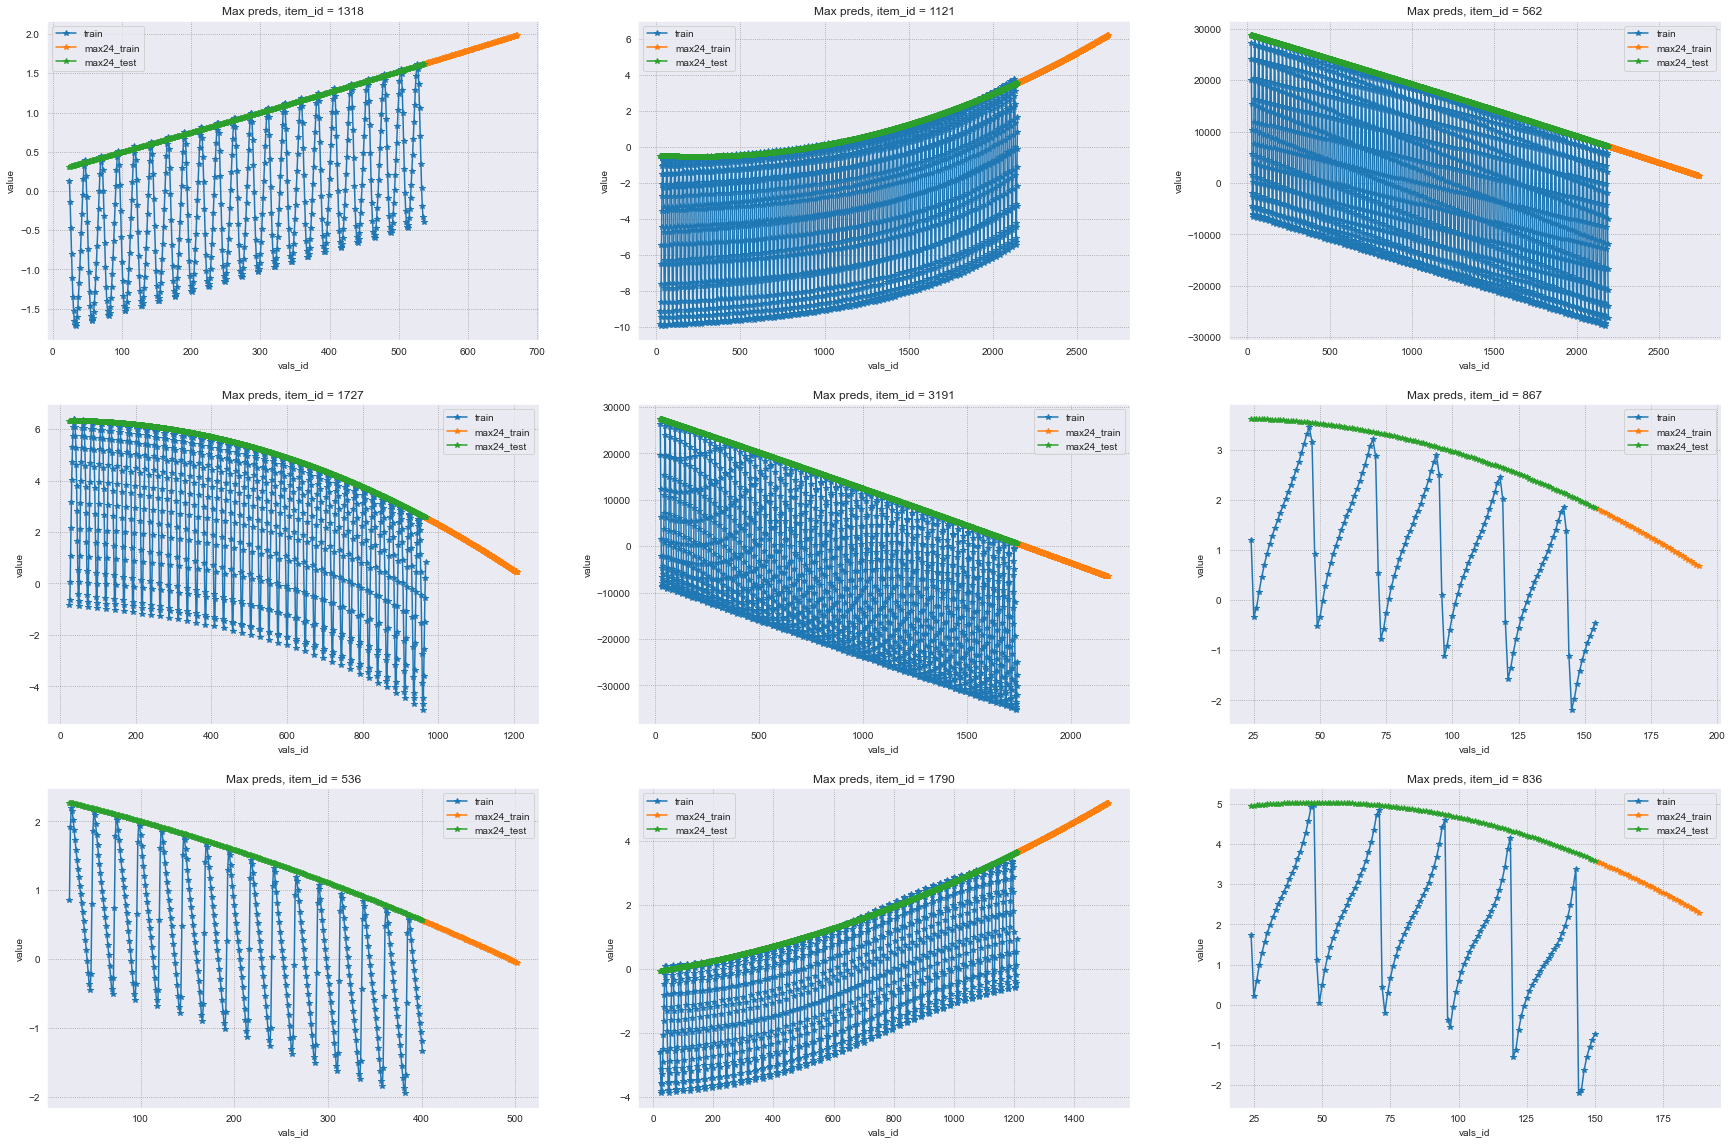

In [24]:
# визуализируем 9 случайных результатов
random_ind = np.random.choice(list(set(df_train['item_id'].values)), 9, replace=False)
plt.figure(figsize = (30, 20))
for i, j in enumerate(random_ind):
    ax = plt.subplot(round(len(random_ind) / 3), 3, i + 1)
    ax.set_title(f'Max preds, item_id = {j}')
    ax.plot(np.array(df_train[df_train['item_id'] == j]['vals_id']),
             np.array(df_train[df_train['item_id'] == j]['value']), label='train', marker = '*')
    ax.plot(np.array(df_test[df_test['item_id'] == j]['vals_id']),
         np.array(df_test[df_test['item_id'] == j]['max24']), label = 'max24_train',
        marker = '*')
    ax.plot(np.array(df_train[df_train['item_id'] == j]['vals_id']),
         np.array(df_train[df_train['item_id'] == j]['max24']), label = 'max24_test',
        marker = '*')
    ax.legend()
    ax.set_xlabel('vals_id')
    ax.set_ylabel('value')
plt.show()

In [22]:
from sklearn.linear_model import LinearRegression

train_min24 = []
test_min24 = []

for item_id in tqdm(set(df_train['item_id'].values)):
    
    train =  np.array(df_train[df_train['item_id'] == item_id]['vals_id'])
    test = np.array(df_test[df_test['item_id'] == item_id]['vals_id'])
    
    X_train = np.concatenate([[train], [train ** 2]], axis = 0).T
    y_train =  np.array(df_train[df_train['item_id'] == item_id]['min24'])
    X_test = np.concatenate([[test], [test ** 2]], axis = 0).T
    
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)
    train_min24 += list(train_preds)
    test_min24 += list(test_preds)
    
print(len(train_min24), len(df_train))
print(len(test_min24), len(df_test))

100%|██████████████████████████████████████████████████████████████████████████████| 3600/3600 [01:06<00:00, 54.12it/s]

3029334 3029334
780762 780762


In [23]:
df_train['min24'] = train_min24
df_test['min24'] = test_min24

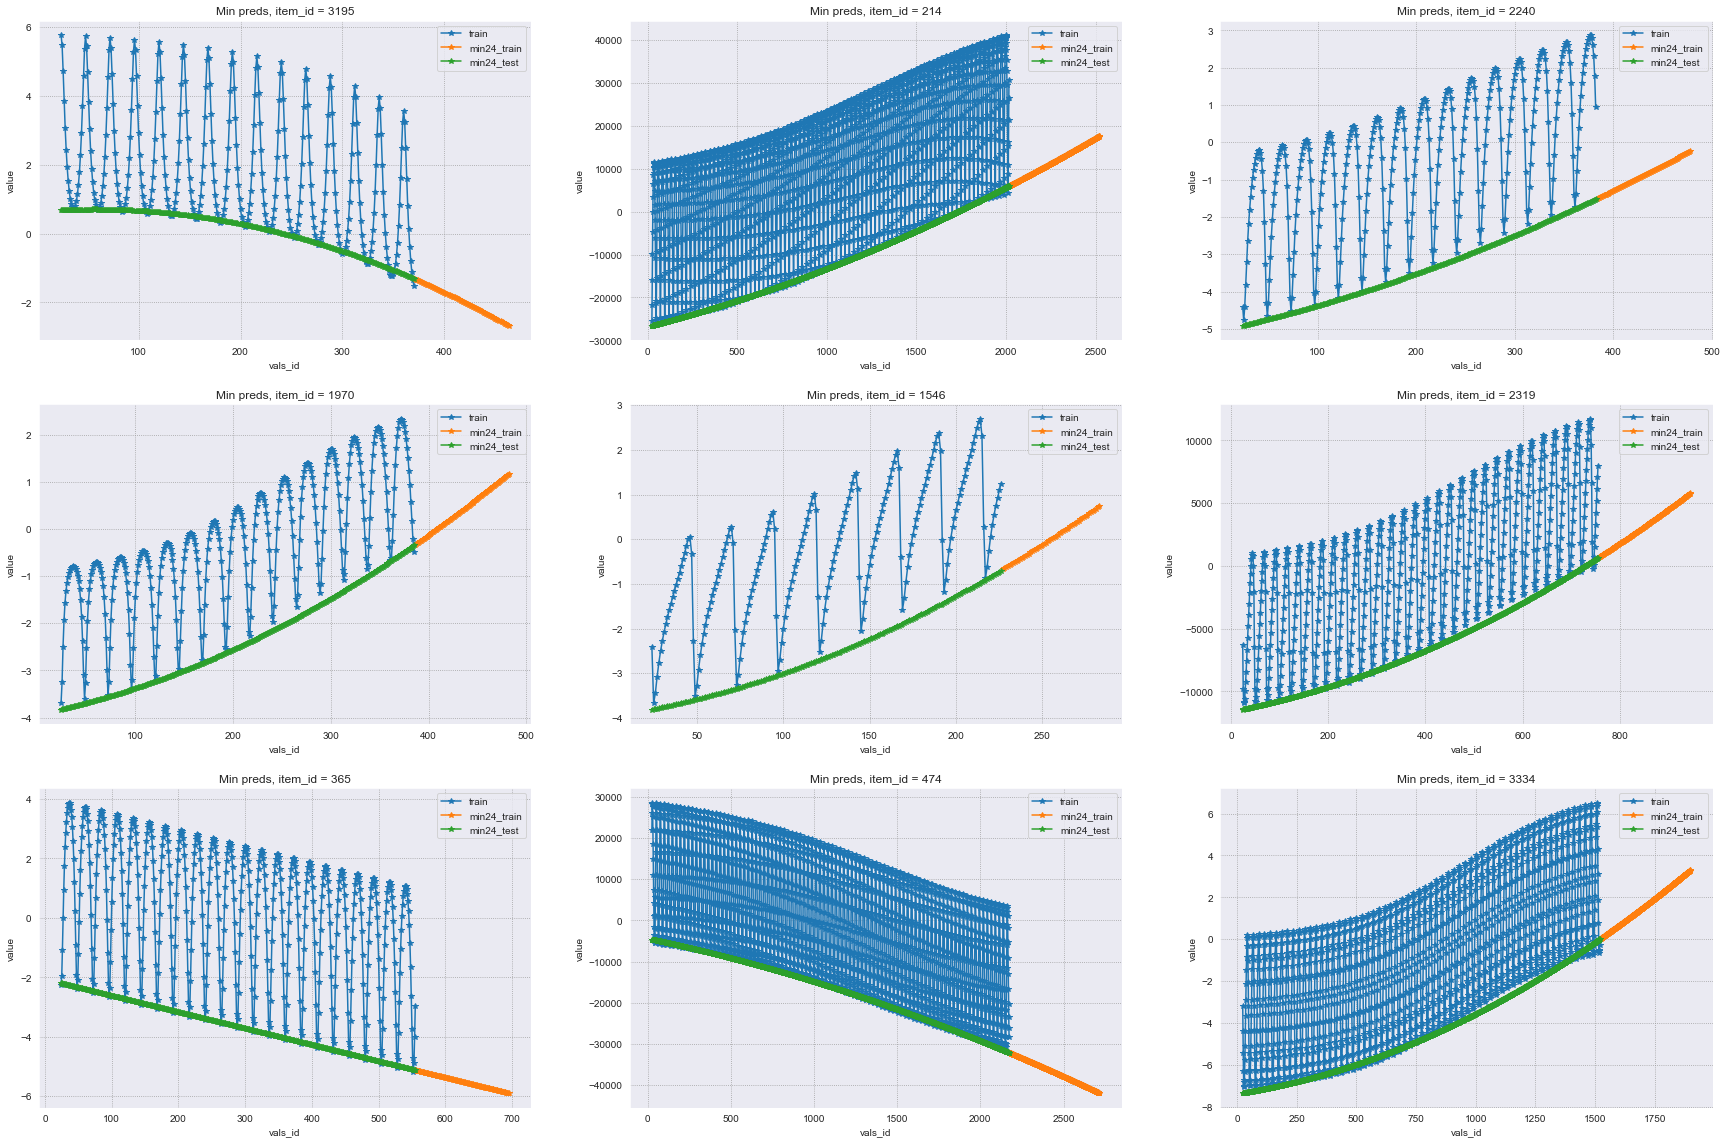

In [25]:
# визуализируем 9 случайных результатов
random_ind = np.random.choice(list(set(df_train['item_id'].values)), 9, replace=False)
plt.figure(figsize = (30, 20))
for i, j in enumerate(random_ind):
    ax = plt.subplot(round(len(random_ind) / 3), 3, i + 1)
    ax.set_title(f'Min preds, item_id = {j}')
    ax.plot(np.array(df_train[df_train['item_id'] == j]['vals_id']),
             np.array(df_train[df_train['item_id'] == j]['value']), label='train', marker = '*')
    ax.plot(np.array(df_test[df_test['item_id'] == j]['vals_id']),
         np.array(df_test[df_test['item_id'] == j]['min24']), label = 'min24_train',
        marker = '*')

    ax.plot(np.array(df_train[df_train['item_id'] == j]['vals_id']),
         np.array(df_train[df_train['item_id'] == j]['min24']), label = 'min24_test',
        marker = '*')
    ax.legend()
    ax.set_xlabel('vals_id')
    ax.set_ylabel('value')
plt.show()

In [20]:
df_train.head()

,item_id,vals_id,epoch,value,trend,lag1,lag2,lag3,lag4,lag5,...,lag17,lag18,lag19,lag20,lag21,lag22,lag23,lag24,min24,max24
24,0,24,2014-01-01 07:34:48,3.226615,4.883580,4.796321,6.358080,7.749572,8.853890,9.609826,...,1.279133,0.509548,0.003750,-0.161371,0.077846,0.751695,1.835517,3.237531,-0.361362,9.861314
25,0,25,2014-01-01 07:53:45,1.825609,4.883868,3.226615,4.796321,6.358080,7.749572,8.853890,...,2.235956,1.279133,0.509548,0.003750,-0.161371,0.077846,0.751695,1.835517,-0.361023,9.861587
26,0,26,2014-01-01 08:12:42,0.743142,4.884156,1.825609,3.226615,4.796321,6.358080,7.749572,...,3.310611,2.235956,1.279133,0.509548,0.003750,-0.161371,0.077846,0.751695,-0.360685,9.861859
27,0,27,2014-01-01 08:31:39,0.070691,4.884443,0.743142,1.825609,3.226615,4.796321,6.358080,...,4.442755,3.310611,2.235956,1.279133,0.509548,0.003750,-0.161371,0.077846,-0.360348,9.862130
28,0,28,2014-01-01 08:50:36,-0.167343,4.884728,0.070691,0.743142,1.825609,3.226615,4.796321,...,5.580232,4.442755,3.310611,2.235956,1.279133,0.509548,0.003750,-0.161371,-0.360011,9.862401


# Предсказания занчений рядов

In [21]:
def get_last_vals(df_train, size):
    result = pd.DataFrame([])
    for item_id in tqdm(pd.unique(df_train['item_id'])):
        max_val = df_train[df_train['item_id'] == item_id]['vals_id'].max()
        last_values = df_train[(df_train['item_id'] == item_id) & 
                df_train['vals_id'].isin(list(range(max_val - size + 1, max_val + 1)))]
        result = pd.concat([result, last_values])
    return result

In [22]:
last_values = get_last_vals(df_train, num_lags)
last_values.head()

100%|██████████████████████████████████████████████████████████████████████████████| 3600/3600 [05:24<00:00, 11.09it/s]


,item_id,vals_id,epoch,value,trend,lag1,lag2,lag3,lag4,lag5,...,lag17,lag18,lag19,lag20,lag21,lag22,lag23,lag24,min24,max24
3622,0,3622,2014-02-17 15:56:54,0.694966,0.318011,2.158497,3.382597,4.273120,4.792776,4.949545,...,-4.674026,-4.936948,-4.848388,-4.364551,-3.479224,-2.242032,-0.765140,0.791408,-4.702666,5.233477
3623,0,3623,2014-02-17 16:15:51,-0.861406,0.315184,0.694966,2.158497,3.382597,4.273120,4.792776,...,-4.121946,-4.674026,-4.936948,-4.848388,-4.364551,-3.479224,-2.242032,-0.765140,-4.705420,5.230631
3624,0,3624,2014-02-17 16:34:48,-2.337535,0.312356,-0.861406,0.694966,2.158497,3.382597,4.273120,...,-3.347591,-4.121946,-4.674026,-4.936948,-4.848388,-4.364551,-3.479224,-2.242032,-4.708174,5.227783
3625,0,3625,2014-02-17 16:53:45,-3.573553,0.309527,-2.337535,-0.861406,0.694966,2.158497,3.382597,...,-2.414549,-3.347591,-4.121946,-4.674026,-4.936948,-4.848388,-4.364551,-3.479224,-4.710928,5.224935
3626,0,3626,2014-02-17 17:12:42,-4.457576,0.306697,-3.573553,-2.337535,-0.861406,0.694966,2.158497,...,-1.380061,-2.414549,-3.347591,-4.121946,-4.674026,-4.936948,-4.848388,-4.364551,-4.713684,5.222086


In [23]:
columns = ['vals_id', 'lag1','lag2','lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9','lag10',
           'lag11' ,'lag12', 'lag13', 'lag14', 'lag15', 'lag16','lag17', 'lag18', 'lag19', 'lag20',
            'lag21', 'lag22', 'lag23','lag24', 'trend', 'min24', 'max24']

In [25]:
from sklearn.linear_model import Ridge

def make_prediction(df_train, df, last_vals, cols, num_lags):
    df_test = df.copy()
    
    features_creted = []
    res = []

    for _, row in tqdm(df_test.iterrows()): 
        if row['item_id'] in features_creted:
            
            row['lag1'] = prev_row['value']
            for i in range(2, num_lags + 1):
                row[f'lag{i}'] = prev_row[f'lag{i - 1}']
                                
            value = model.predict(np.array([np.array(row[cols])]))
            
            row['value'] = value[0]
            res_row = row[['item_id', 'vals_id', 'value']].to_list()
            res.append(res_row)

            prev_row = row.copy()
        else:
                
            df_item = df_train[df_train['item_id'] == row['item_id']]
            
            X_train = np.array(df_item[cols])
            y_train = np.array(df_item['value'])
            
            model = Ridge(random_state=42)
            model.fit(X_train, y_train)
            
            features_creted.append(row['item_id'])
            features = last_vals[last_vals['item_id'] == row['item_id']]
            
            for i in range(1, num_lags + 1):
                row[f'lag{i}'] = features.iloc[num_lags - i]['value']
            
            value = model.predict(np.array([np.array(row[cols])]))
            row['value'] = value[0]
            res_row = row[['item_id', 'vals_id', 'value']].to_list()
            res.append(res_row)
            prev_row = row.copy()
            
    res = pd.DataFrame(res, columns = ['item_id', 'vals_id','value'])
    return res

In [30]:
res = make_prediction(df_train, df_test, last_values, columns, num_lags)

780762it [2:48:50, 77.07it/s] 


In [27]:
res

,item_id,vals_id,value
0,0,3646,0.593999
1,0,3647,-0.958486
2,0,3648,-2.429842
3,0,3649,-3.664158
4,0,3650,-4.550063
...,...,...,...
780757,3599,1500,1.562412
780758,3599,1501,2.115565
780759,3599,1502,2.743234
780760,3599,1503,3.434986


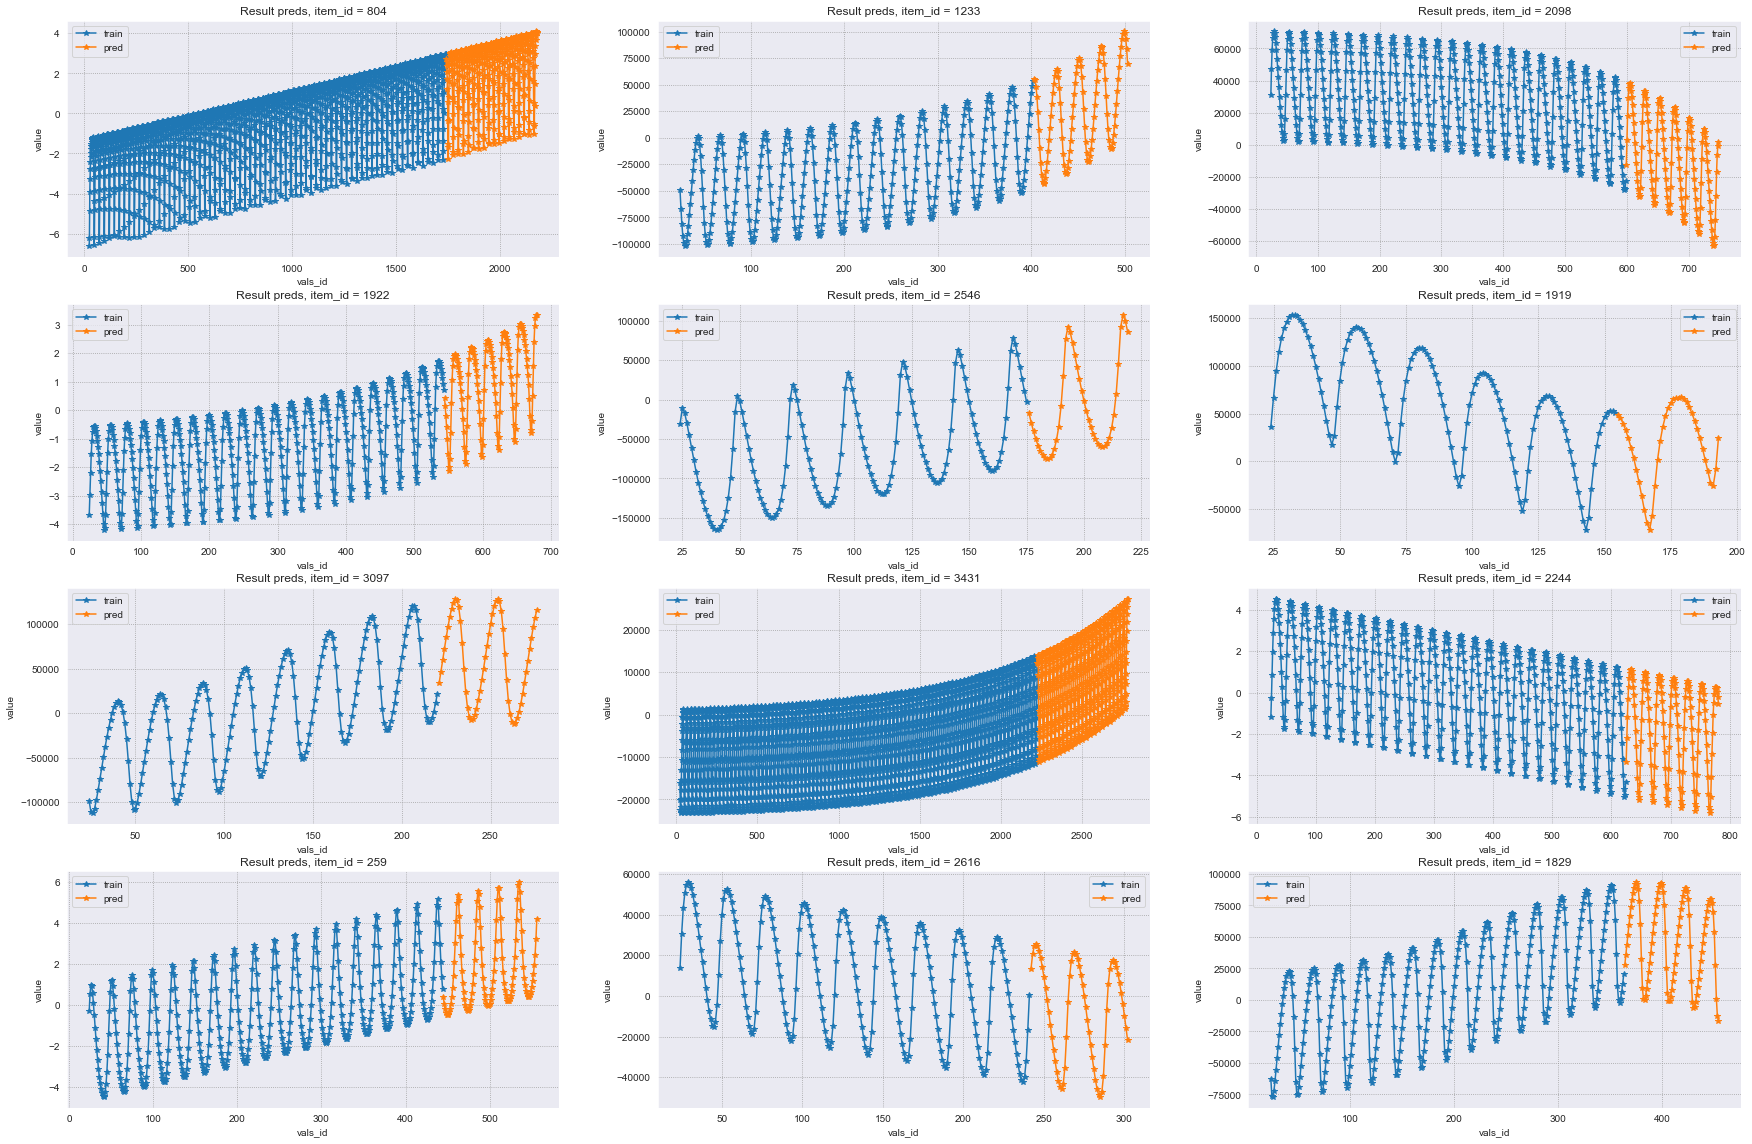

In [28]:
# визуализируем 12 случайных результатов
random_ind = np.random.choice(list(set(df_train['item_id'].values)), 12, replace=False)
plt.figure(figsize = (30, 20))
for i, j in enumerate(random_ind):
    ax = plt.subplot(round(len(random_ind) / 3), 3, i + 1)
    ax.set_title(f'Result preds, item_id = {j}')
    ax.plot(np.array(df_train[df_train['item_id'] == j]['vals_id']),
         np.array(df_train[df_train['item_id'] == j]['value']), label='train', marker = '*')
    ax.plot(np.array(res[res['item_id'] == j]['vals_id']),
            np.array(res[res['item_id'] == j]['value']), label = 'pred', marker = '*')
    ax.legend()
    ax.set_xlabel('vals_id')
    ax.set_ylabel('value')
plt.show()

In [33]:
res.to_csv('res_miltiridge24.csv', index=False)

In [34]:
res = res.astype({'item_id': int, 'vals_id': int})
res = res.astype({'item_id': str, 'vals_id': str})

res_submit = pd.DataFrame()

res_submit['row'] = res['item_id'] + '_'+ res['vals_id']
res_submit['value'] = res['value']

res_submit

,row,value
0,0_3646,0.593999
1,0_3647,-0.958486
2,0_3648,-2.429842
3,0_3649,-3.664158
4,0_3650,-4.550063
...,...,...
780757,3599_1500,1.562412
780758,3599_1501,2.115565
780759,3599_1502,2.743234
780760,3599_1503,3.434986


In [35]:
res_submit.to_csv('submit_miltiridge_lag24.csv', index=False)

# Итоги

По графикам видно, особенно если позапускать несколько раз, что решение не идеальное и некоторые ряды утягиваются за счёт скорее всего признаков тренда, скользящего минимума и максимума, но при этом решение пробивает первый бейслайн. Нужно дальше развивать идею, посмотрим, что получится.